In [ ]:
#Creates directories for data to be stored
!mkdir /content/db/
!mkdir /content/db/chb01/

#Pulls patient 01's files from a Google Cloud Storage
#For the sake of saving grader's time we will only be using 1 patients files
!gsutil -m cp -r gs://chbmit-1.0.0.physionet.org/chb01/* /content/db/chb01/

mkdir: cannot create directory ‘/content/db/’: File exists
mkdir: cannot create directory ‘/content/db/chb01/’: File exists
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01-summary.txt...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_01.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_03.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_03.edf.seizures...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_04.edf.seizures...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_02.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_06.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_04.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_07.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_05.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_08.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_09.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_10.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/c

In [ ]:
%matplotlib inline

#Installation of MNE for colab, Causes errors but still works
!wget "https://raw.githubusercontent.com/mne-tools/mne-python/master/requirements.txt"
!pip install -r "/content/requirements.txt"
!pip install -U mne
import mne
import numpy as np
import pandas as pd
import sys

--2020-03-18 05:30:19--  https://raw.githubusercontent.com/mne-tools/mne-python/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 482 [text/plain]
Saving to: ‘requirements.txt.2’

requirements.txt.2  100%[===================>]     482  --.-KB/s    in 0s      

2020-03-18 05:30:19 (73.7 MB/s) - ‘requirements.txt.2’ saved [482/482]

  Using cached https://api.github.com/repos/numpy/numpydoc/zipball/master
  Using cached https://api.github.com/repos/mcmtroffaes/sphinxcontrib-bibtex/zipball/29694f215b39d64a31b845aafd9ff2ae9329494f
  Using cached https://files.pythonhosted.org/packages/08/ea/eb808cb4df8f92bc4d9f9a1ef14566b9b5d60370e6ecbaf9061cdae335fa/mayavi-4.7.1.tar.bz2
  Using cached https://files.pythonhosted.org/packages/3f/86/2b6a2a50166b6d

In [ ]:
#Makes a labels array for a given file
def make_labels(filename):
  #Open summary file for reading
  with open('/content/db/chb01/chb01-summary.txt', 'r') as f:
    data = f.read()
  
  #Parse through looking for specific file
  for x in range(0, len(data)):
    if data[x:x+23] == "File Name: " + filename:

      #Get number of seizures
      numSeiz = int(data[x+102:x+103])
      labels = np.zeros(720)

      #If 1 get start and end times and edits zeros array
      if numSeiz == 1:
        start = int(data[x+124:x+128])
        startIter = int(start/5)
        end = int(data[x+155:x+159])
        endIter = int(end/5)
        for iter in range(startIter, endIter):
          labels[iter] = 1

      #If 2 placehold for now
      elif numSeiz == 2:
        print("2 is not ready yet")
        exit

      return labels

In [ ]:
#Given filename returns data in correct format
def make_data(filename):
  path = "/content/db/chb01/" + filename
  data = mne.io.read_raw_edf(path,preload=True).get_data()
  data = data.reshape(720, 256, 23, 5)
  return data

In [ ]:
#Used to install Tensorflow
import tensorflow as tf

#Make the training data
file3        = "chb01_03.edf"
train_data   = make_data(file3)
train_labels = make_labels(file3)

#Make the test data
file4       = "chb01_04.edf"
test_data   = make_data(file4)
test_labels = make_labels(file4)


Extracting EDF parameters from /content/db/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-5669a0484ebd>:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(path,preload=True).get_data()


Extracting EDF parameters from /content/db/chb01/chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-22-5669a0484ebd>:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(path,preload=True).get_data()


In [ ]:
# Load some neural network functions we'll be using.
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model

# Our input feature map is 720x1280x23
eeg_input = Input(shape=(256, 23, 5))

#We start with 3 convolutional layers with kernels based on EEG channels
#We use an AvgPool layer since each channel should increase in activity during a seizure
c1 = Conv2D(filters=16, kernel_size=(23, 5))(eeg_input)
a1 = AveragePooling2D(pool_size=2)(c1)
c2 = Conv2D(filters=32, kernel_size=(23, 5))(a1)
a2 = AveragePooling2D(pool_size=2)(c2)
c3 = Conv2D(filters=64, kernel_size=(23, 1))(a2)
a3 = AveragePooling2D(pool_size=2)(c3)

f1 = Flatten()(a3)
d1 = Dense(256, activation='relu')(f1)
output = Dense(1, activation='sigmoid')(d1)
model = Model(eeg_input, output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 23, 5)]      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 234, 19, 16)       9216      
_________________________________________________________________
average_pooling2d_3 (Average (None, 117, 9, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 95, 5, 32)         58912     
_________________________________________________________________
average_pooling2d_4 (Average (None, 47, 2, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 2, 64)         47168     
_________________________________________________________________
average_pooling2d_5 (Average (None, 12, 1, 64)         0   

In [ ]:
#Compile the model
from tensorflow.keras.optimizers import RMSprop

model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['acc'])

In [ ]:
history = model.fit(
    x=train_data, 
    y=train_labels, 
    batch_size=720, 
    epochs= 20, 
    validation_split=0.2)

Train on 576 samples, validate on 144 samples
Epoch 1/20
576/576 [==============================] - 13s 23ms/sample - loss: 0.6931 - acc: 0.7049 - val_loss: 0.6629 - val_acc: 0.9444
Epoch 2/20
576/576 [==============================] - 13s 23ms/sample - loss: 0.6590 - acc: 1.0000 - val_loss: 0.3206 - val_acc: 0.9444
Epoch 3/20
576/576 [==============================] - 13s 23ms/sample - loss: 0.2509 - acc: 1.0000 - val_loss: 0.8960 - val_acc: 0.9444
Epoch 4/20
576/576 [==============================] - 13s 22ms/sample - loss: 9.8909e-08 - acc: 1.0000 - val_loss: 0.8963 - val_acc: 0.9444
Epoch 5/20
576/576 [==============================] - 13s 22ms/sample - loss: 9.8398e-08 - acc: 1.0000 - val_loss: 0.8966 - val_acc: 0.9444
Epoch 6/20
576/576 [==============================] - 13s 22ms/sample - loss: 9.7982e-08 - acc: 1.0000 - val_loss: 0.8967 - val_acc: 0.9444
Epoch 7/20
576/576 [==============================] - 13s 22ms/sample - loss: 9.7697e-08 - acc: 1.0000 - val_loss: 0.8968 - va

In [ ]:
# Evaluate the model's performance
train_loss, train_acc = model.evaluate(train_data, train_labels)
test_loss, test_acc = model.evaluate(test_data, test_labels)

print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

720/720 [==============================] - 4s 5ms/sample - loss: 0.1122 - acc: 0.9931
Training set accuracy: 0.98888886
Test set accuracy: 0.9930556


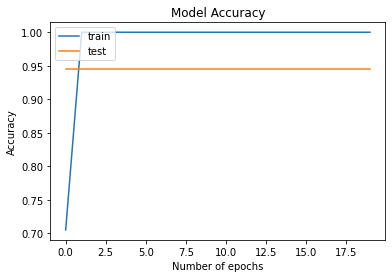

In [ ]:
import matplotlib.pyplot as plt

# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

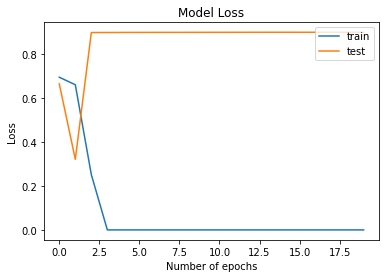

In [ ]:
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

We can now test on any other file from this patient using the same methods as above and yield similar results. This can also be done by importing any other patient however to save space we are only showing this one example. We have also removed all previous unnecessary code from the file but if you would like to see the previous iterations please check the edit history. 

Thanks for your time - Elijah, John, and Sruthi
